In [33]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
def fast_filter(x, theta, L):
    ''' Fast localized spectral filter
    INPUT
        x: input signal in R^d
        theta: filter parameters in R^K
        L: Graph laplacian in R^{d*d}
    OUTPUT
        filtered signal y in R^d
    '''
    lambda_max = max(np.linalg.eig(L)[0]) # maximum eigenvalue
    K = theta.size
    L_tilde = 2*L/lambda_max - np.eye(L.shape[0])
    
    X = np.zeros((x.size, K)) # matrix to store all x_bar's
    X[:, 0] = x
    X[:, 1] = np.matmul(L_tilde, x)
    # compute tchebitchev recursion
    for k in range(2, K):
        X[:, k] = 2 * np.matmul(L_tilde, X[:, k-1]) - X[:, k-2]
    # return filtered signal
    return np.matmul(X, theta)

In [35]:
np.random.rand(100)

array([ 0.07289259,  0.34044495,  0.22942415,  0.75077971,  0.33981615,
        0.55130051,  0.06814375,  0.74777494,  0.40190224,  0.05830574,
        0.41520821,  0.54376253,  0.64292086,  0.55976346,  0.87548066,
        0.92240992,  0.16215408,  0.43628452,  0.84062254,  0.87160362,
        0.3187785 ,  0.0908055 ,  0.84491237,  0.70192749,  0.31974219,
        0.21633217,  0.88816061,  0.19221608,  0.07588233,  0.86349898,
        0.63141592,  0.91506086,  0.17773198,  0.20901454,  0.24525036,
        0.63547987,  0.24195722,  0.44958328,  0.45597901,  0.01308744,
        0.91473332,  0.14771663,  0.29229091,  0.1525194 ,  0.30876425,
        0.11397657,  0.92203574,  0.91965638,  0.53242243,  0.62009193,
        0.94190728,  0.06083401,  0.21337775,  0.15389446,  0.10404996,
        0.19419881,  0.4586136 ,  0.84021407,  0.85914748,  0.41340839,
        0.06020929,  0.01678208,  0.37301281,  0.24379347,  0.44566889,
        0.92082174,  0.40674506,  0.43045689,  0.19818159,  0.47

In [436]:
n = 100
W=np.random.randint(2, size=(n,n))
W = W*W.T # make symetric
W[range(n), range(n)]=0 # remove diag
print(W)

[[0 0 0 ..., 0 0 1]
 [0 0 0 ..., 1 0 1]
 [0 0 0 ..., 1 0 0]
 ..., 
 [0 1 1 ..., 0 0 1]
 [0 0 0 ..., 0 0 0]
 [1 1 0 ..., 1 0 0]]


In [437]:
L = np.diag(sum(W)) - W
print(L)

[[20  0  0 ...,  0  0 -1]
 [ 0 31  0 ..., -1  0 -1]
 [ 0  0 20 ..., -1  0  0]
 ..., 
 [ 0 -1 -1 ..., 26  0 -1]
 [ 0  0  0 ...,  0 31  0]
 [-1 -1  0 ..., -1  0 43]]


In [438]:
x = np.sin(2 * np.pi * np.linspace(0, 1, n)) + np.random.normal(0, 0.1, n)

theta [ 0.24822005  0.80117745  0.37803134  0.42759311  0.68884479  0.89858242]


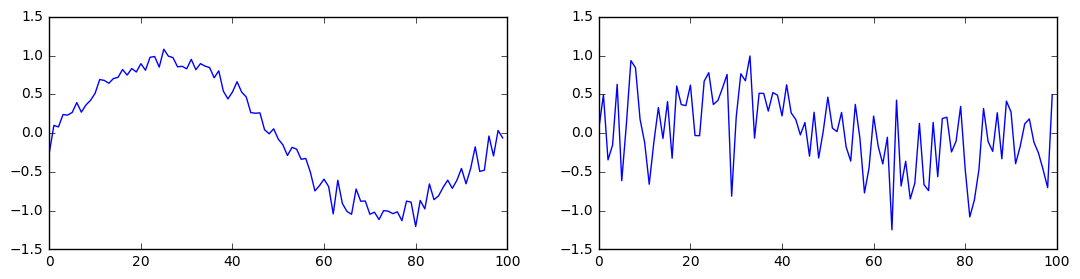

In [439]:
fig = plt.figure(figsize=(13, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)

ax1.plot(x)
theta = np.random.rand(6)
print("theta", theta)
ax2.plot(fast_filter(x, theta, L))

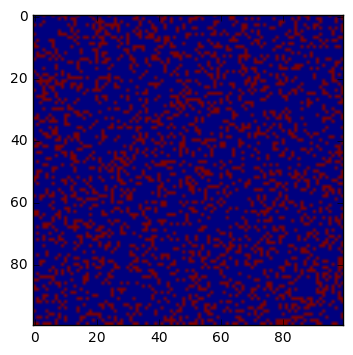

In [440]:
plt.imshow(W)

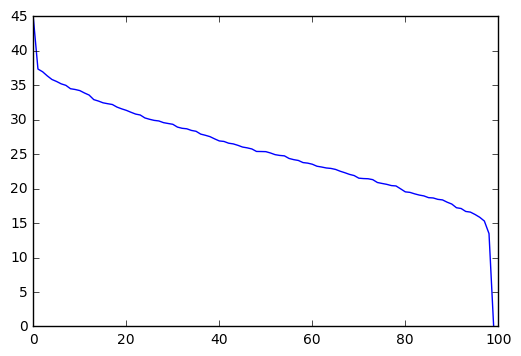

In [441]:
plt.plot(np.sort(np.linalg.eig(L)[0])[::-1])

In [442]:
np.sort(np.linalg.eig(L)[0])

array([  0.        ,  13.47837966,  15.30140984,  15.84868205,
        16.25216888,  16.59716714,  16.6924232 ,  17.12033046,
        17.231714  ,  17.76638395,  18.03643994,  18.36807809,
        18.44904024,  18.65004191,  18.69473707,  18.94900702,
        19.07122607,  19.24911469,  19.46077998,  19.53692166,
        19.9706812 ,  20.39400921,  20.44827156,  20.6286043 ,
        20.75681322,  20.89547628,  21.30797417,  21.43918105,
        21.46621985,  21.5243385 ,  21.90302824,  22.07330706,
        22.31400823,  22.53086614,  22.79345162,  22.93899827,
        23.00457256,  23.14249017,  23.2573187 ,  23.54786554,
        23.70907287,  23.78748995,  24.09387355,  24.21352334,
        24.3853819 ,  24.76282696,  24.82319622,  24.93764657,
        25.17956647,  25.37374457,  25.39149412,  25.40297523,
        25.76507568,  25.9246544 ,  26.04146544,  26.29111114,
        26.49855386,  26.60222118,  26.85469583,  26.92881102,
        27.22667731,  27.55049501,  27.74898246,  27.92

# In tensorflow??

In [500]:
import tensorflow as tf
tf.reset_default_graph()

We first build the filter with symbolic variables

In [501]:
K = 6
theta_tf = tf.Variable(np.array(np.random.uniform(-1, 1, size=(K,1)), dtype=np.float32))
X_tf = tf.placeholder(tf.float32, [None, K])
y_tf = tf.matmul(X_tf, theta_tf)
y_target = tf.placeholder(tf.float32, [None, 1])
loss_tf = tf.reduce_sum((y_tf - y_target)**2)

In [502]:
# function to get the matrix with all chebitchev
def return_X(x, K, L):
    ''' Fast localized spectral filter
    INPUT
        x: input signal in R^d
        theta: filter parameters in R^K
        L: Graph laplacian in R^{d*d}
    OUTPUT
        filtered signal y in R^d
    '''
    lambda_max = max(np.linalg.eig(L)[0]) # maximum eigenvalue
    L_tilde = 2*L/lambda_max - np.eye(L.shape[0])
    
    X = np.zeros((x.size, K)) # matrix to store all x_bar's
    X[:, 0] = x
    X[:, 1] = np.matmul(L_tilde, x)
    # compute tchebitchev recursion
    for k in range(2, K):
        X[:, k] = 2 * np.matmul(L_tilde, X[:, k-1]) - X[:, k-2]
    # return filtered signal
    return X

We now generate the $\bar X$ matrix

In [503]:
X_bar = return_X(x, K, L)

And now we can gte back the filtered version using TF

In [504]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

[y_tf_result, loss] = sess.run([y_tf, loss_tf], feed_dict={
        X_tf: X_bar, 
        #theta_tf: theta.reshape((-1,1)),
        y_target: fast_filter(x, theta, L).reshape((-1,1))
    })

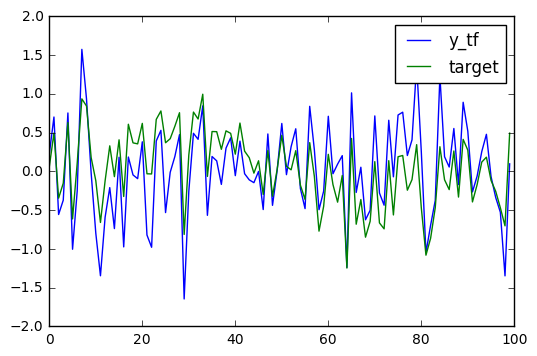

In [505]:
plt.plot(y_tf_result)
plt.plot(fast_filter(x, theta, L))
plt.legend(["y_tf", "target"])

We see with the plot that the filtered version is not the same at all than the one we computed using numpy and our fast_filter function. This is totally normal since we initialized our theta_tf at random! We can quantify the difference with the loss:

In [506]:
print("loss", loss)

loss 16.9707


What we will try now is to optimize the theta_tf using Gradient descend to get approximately the same filtered signal as the one with our previously chosen $\theta$. Be careful, the gradient descend is really sensitive to the learning rate and may diverge if it is too large.

In [507]:
train_step = tf.train.GradientDescentOptimizer(0.001).minimize(loss_tf, var_list=[theta_tf])

In [508]:
for i in range(101):
    sess.run(train_step, feed_dict={
            X_tf: X_bar, 
            #theta_tf: theta.reshape((-1,1)),
            y_target: fast_filter(x, theta, L).reshape((-1,1))
        })
    [current_loss] = sess.run([loss_tf], feed_dict={
        X_tf: X_bar, 
        #theta_tf: theta.reshape((-1,1)),
        y_target: fast_filter(x, theta, L).reshape((-1,1))
    })
    if i%10==0:
        print("{}\tloss: {}".format(i,current_loss,2))

0	loss: 13.46578598022461
10	loss: 5.209342956542969
20	loss: 3.358595848083496
30	loss: 2.2684812545776367
40	loss: 1.6073660850524902
50	loss: 1.2056543827056885
60	loss: 0.9609960317611694
70	loss: 0.8114309310913086
80	loss: 0.7194507122039795
90	loss: 0.6623469591140747
100	loss: 0.6263719797134399


We can retrieve our filtered signal and plot it with our initial filtered signal:

In [509]:
y_tf_result = sess.run(y_tf, feed_dict={
        X_tf: X_bar, 
        #theta_tf: theta.reshape((-1,1)),
        y_target: fast_filter(x, theta, L).reshape((-1,1))
    })

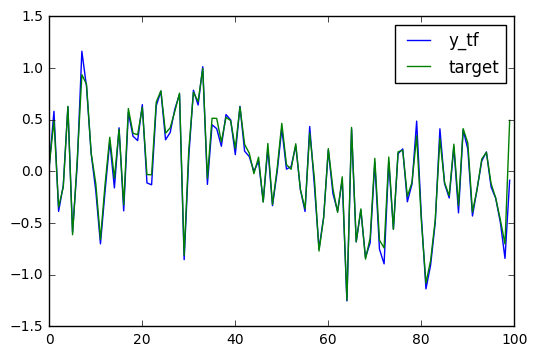

In [510]:
plt.plot(y_tf_result)
plt.plot(fast_filter(x, theta, L))
plt.legend(["y_tf", "target"])

We can finally compare the learnt theta_tf and the true $\theta$:

In [511]:
theta_learnt = sess.run([theta_tf], feed_dict={X_tf: X_bar})[0].reshape((-1))
print("theta learnt", theta_learnt)
print("theta target", theta)

theta learnt [-0.46862084 -0.74437165 -0.6608364  -0.54917181  0.3491537   0.60386634]
theta target [ 0.24822005  0.80117745  0.37803134  0.42759311  0.68884479  0.89858242]
